# Proyecto: Analítica de Showz

## Descripción del proyecto

Lo has hecho de maravilla en el curso de TripleTen y te han ofrecido hacer prácticas en el departamento de analítica de Showz, una empresa de venta de entradas de eventos. Tu primera tarea es ayudar a optimizar los gastos de marketing. 

Cuentas con:

registros del servidor con datos sobre las visitas a Showz desde enero de 2017 hasta diciembre de 2018;
un archivo con los pedidos en este periodo;
estadísticas de gastos de marketing.
Lo que vas a investigar: 

cómo los clientes usan el servicio;
cuándo empiezan a comprar;
cuánto dinero aporta cada cliente a la compañía;
cuándo los ingresos cubren el costo de adquisición de los clientes.

# Acceso y preparación de datos 

In [1]:
#importar librerías 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [2]:
df_visits = pd.read_csv('/datasets/visits_log_us.csv')
df_orders = pd.read_csv('/datasets/orders_log_us.csv')
df_costs = pd.read_csv('/datasets/costs_us.csv')

## Estudiar los df

In [3]:
print(df_visits.head())
print(df_visits.info())

    Device               End Ts  Source Id             Start Ts  \
0    touch  2017-12-20 17:38:00          4  2017-12-20 17:20:00   
1  desktop  2018-02-19 17:21:00          2  2018-02-19 16:53:00   
2    touch  2017-07-01 01:54:00          5  2017-07-01 01:54:00   
3  desktop  2018-05-20 11:23:00          9  2018-05-20 10:59:00   
4  desktop  2017-12-27 14:06:00          3  2017-12-27 14:06:00   

                    Uid  
0  16879256277535980062  
1    104060357244891740  
2   7459035603376831527  
3  16174680259334210214  
4   9969694820036681168  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   Device     359400 non-null  object
 1   End Ts     359400 non-null  object
 2   Source Id  359400 non-null  int64 
 3   Start Ts   359400 non-null  object
 4   Uid        359400 non-null  uint64
dtypes: int64(1), object(3), uint64(1)
memory usage

In [4]:
print(df_orders.head())
print()
print(df_orders.info())

                Buy Ts  Revenue                   Uid
0  2017-06-01 00:10:00    17.00  10329302124590727494
1  2017-06-01 00:25:00     0.55  11627257723692907447
2  2017-06-01 00:27:00     0.37  17903680561304213844
3  2017-06-01 00:29:00     0.55  16109239769442553005
4  2017-06-01 07:58:00     0.37  14200605875248379450

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Buy Ts   50415 non-null  object 
 1   Revenue  50415 non-null  float64
 2   Uid      50415 non-null  uint64 
dtypes: float64(1), object(1), uint64(1)
memory usage: 1.2+ MB
None


In [5]:
print(df_costs.head())
print()
print(df_costs.info())

   source_id          dt  costs
0          1  2017-06-01  75.20
1          1  2017-06-02  62.25
2          1  2017-06-03  36.53
3          1  2017-06-04  55.00
4          1  2017-06-05  57.08

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   source_id  2542 non-null   int64  
 1   dt         2542 non-null   object 
 2   costs      2542 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 59.7+ KB
None


# Informes y cálculo de métricas

## Visitas

#### ¿Cuántas personas lo usan cada día?

count     364.000000
mean      907.991758
std       370.513838
min         1.000000
25%       594.000000
50%       921.000000
75%      1173.000000
max      3319.000000
Name: Uid, dtype: float64


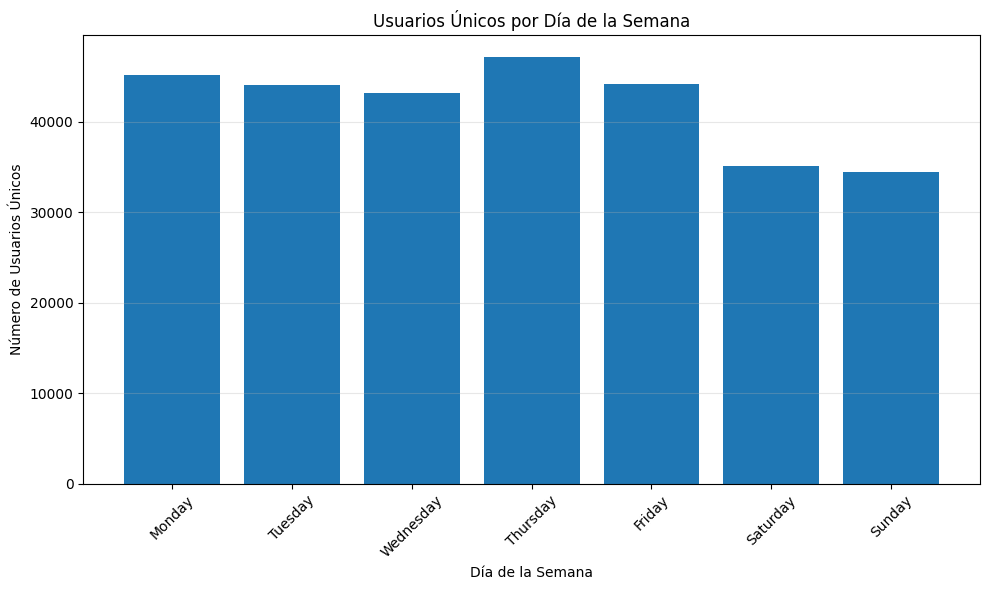

In [6]:
#Días de la semana (DAU)
#Cambiar Start Ts a tipo date_time 
df_visits['date'] = pd.to_datetime(df_visits['Start Ts']).dt.date
# Crear columna de día de la semana
df_visits['day_of_week'] = pd.to_datetime(df_visits['Start Ts']).dt.day_name()
# Usuarios únicos por día de la semana
weekly_pattern = df_visits.groupby('day_of_week')['Uid'].nunique().reset_index()
# Usuarios únicos por día específico
daily_trend = df_visits.groupby('date')['Uid'].nunique().reset_index()
print(daily_trend['Uid'].describe())

# Gráfico de barras
# Definir el orden correcto de los días
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Convertir a categorical con orden específico
weekly_pattern['day_of_week'] = pd.Categorical(weekly_pattern['day_of_week'], 
                                               categories=day_order, 
                                               ordered=True)

# Ordenar el DataFrame
weekly_pattern = weekly_pattern.sort_values('day_of_week')
plt.figure(figsize=(10, 6))
plt.bar(weekly_pattern['day_of_week'], weekly_pattern['Uid'])
plt.title('Usuarios Únicos por Día de la Semana')
plt.xlabel('Día de la Semana')
plt.ylabel('Número de Usuarios Únicos')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

Podemos ver que los jueves tenemos más visitas de usuarios, seguido de los lunes y viernes. Los días que más bajan las visitas son fines de semana. Podríamos pensar que son los días en que los usuarios suelen estar en los eventos para los cuales compran los boletos. 

In [7]:
#Por semana, extraer por semana (WAU)
df_visits['year_week'] = pd.to_datetime(df_visits['Start Ts']).dt.strftime('%Y-W%U')
# Contar visitas por semana
weekly_visits = df_visits.groupby('year_week').size().sort_values(ascending=False)
# Top 5 semanas con más visitas
print("Top 5 semanas con más visitas:")
print(weekly_visits.head())

# Top 5 semanas con menos visitas  
print("\nTop 5 semanas con menos visitas:")
print(weekly_visits.tail())
print()
print('WAU:', weekly_visits.mean())


Top 5 semanas con más visitas:
year_week
2017-W47    13203
2017-W48    10617
2017-W49    10358
2017-W50    10213
2018-W04     9714
dtype: int64

Top 5 semanas con menos visitas:
year_week
2017-W33    3080
2017-W32    2785
2017-W31    2765
2017-W22    1799
2017-W53     784
dtype: int64

WAU: 6655.555555555556


Observamos las semanas con más visitas y con menos visitas, tendríamos que revisar el calendario y ver otras variables para conocer si hubo algún factor que influyera en esas semanas. 

MAU: Uid    23228.416667
dtype: float64


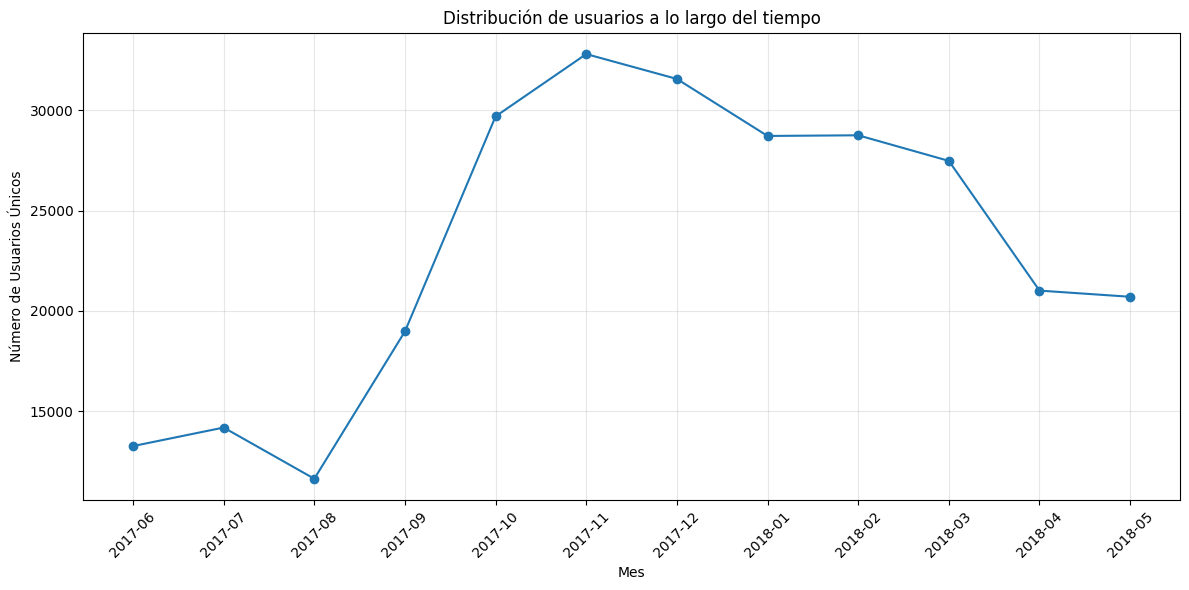

In [8]:
#Por mes (MAU)
# Crear columna de año-mes
df_visits['year_month'] = pd.to_datetime(df_visits['Start Ts']).dt.to_period('M')

# Usuarios únicos por mes
monthly_trend = df_visits.groupby('year_month')['Uid'].nunique().reset_index()
#MAU
print('MAU:', monthly_trend.mean())

# Gráfica de líneas

plt.figure(figsize=(12, 6))
plt.plot(monthly_trend['year_month'].astype(str), monthly_trend['Uid'], marker='o')
plt.title('Distribución de usuarios a lo largo del tiempo')
plt.xlabel('Mes')
plt.ylabel('Número de Usuarios Únicos')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

Observamos que en noviembre del 2017 tenemos un gran aumento en la cantidad de visitas, siendo octubre, noviembre y diciembre de ese año los meses con mayor número de usuarios, disminuyendo progresivamente. 
Asimismo los meses con menos usuarios fueron junio, julio y agosto del 2017. 

#### ¿Cuántas sesiones hay por día? 

In [9]:
#sesiones por usuario
sessions_per_user = df_visits.groupby('date').agg({'Uid': ['count', 'nunique']})
sessions_per_user.columns = ['n_sessions', 'n_users']
sessions_per_user['sess_per_user'] = sessions_per_user['n_sessions'] / sessions_per_user['n_users']
print(sessions_per_user.head())
print()
print('Promedio de sesiones por día: {}'.format(round(sessions_per_user['n_sessions'].mean(),2)))
print('Promedio de sesiones por usuario {} por día'.format(round(sessions_per_user['sess_per_user'].mean(),2)))

            n_sessions  n_users  sess_per_user
date                                          
2017-06-01         664      605       1.097521
2017-06-02         658      608       1.082237
2017-06-03         477      445       1.071910
2017-06-04         510      476       1.071429
2017-06-05         893      820       1.089024

Promedio de sesiones por día: 987.36
Promedio de sesiones por usuario 1.08 por día


Observamos que coincide el número de sesiones por día con el número de usuarios por día, con una mínima variación, ya que la mayoría de usuarios tiene 1-2 sesiones por día. 

#### ¿Cuál es la duración de cada sesión?

In [10]:
df_visits['sess_duration_sec'] = (pd.to_datetime(df_visits['End Ts']) - pd.to_datetime(df_visits['Start Ts'])).dt.total_seconds()
print(df_visits['sess_duration_sec'].describe())

count    359400.000000
mean        643.025687
std         997.127761
min       -2760.000000
25%         120.000000
50%         300.000000
75%         840.000000
max       42660.000000
Name: sess_duration_sec, dtype: float64


Observamos que el promedio de la duración de cada sesión es 643 segundos, aproximadamente 10 minutos. La sesión que duró más tiempo fue de 11 horas aproximadamente. 

#### ¿Con qué frecuencia los usuarios regresan?

In [11]:
#Calcular las primeras sesiones
primeras_visitas = df_visits.groupby('Uid').agg({'date': 'min'}).reset_index()
primeras_visitas.columns = ['Uid','first_session_start_ts']
print(primeras_visitas.head())

               Uid first_session_start_ts
0   11863502262781             2018-03-01
1   49537067089222             2018-02-06
2  297729379853735             2017-06-07
3  313578113262317             2017-09-18
4  325320750514679             2017-09-30


In [12]:
#
primeras_visitas['first_session_dt'] = pd.to_datetime(primeras_visitas['first_session_start_ts']).dt.date
primeras_visitas['first_session_month'] = pd.to_datetime(primeras_visitas['first_session_start_ts']).dt.to_period('M').dt.start_time

In [13]:
#Fusionar
visitas_completo = pd.merge(primeras_visitas, df_visits, on='Uid')
visitas_completo.head()

,Uid,first_session_start_ts,first_session_dt,first_session_month,Device,End Ts,Source Id,Start Ts,date,day_of_week,year_week,year_month,sess_duration_sec
0,11863502262781,2018-03-01,2018-03-01,2018-03-01,touch,2018-03-01 17:33:00,3,2018-03-01 17:27:00,2018-03-01,Thursday,2018-W08,2018-03,360.0
1,49537067089222,2018-02-06,2018-02-06,2018-02-01,touch,2018-02-06 15:57:00,2,2018-02-06 15:55:00,2018-02-06,Tuesday,2018-W05,2018-02,120.0
2,297729379853735,2017-06-07,2017-06-07,2017-06-01,desktop,2017-06-07 18:48:00,3,2017-06-07 18:47:00,2017-06-07,Wednesday,2017-W23,2017-06,60.0
3,313578113262317,2017-09-18,2017-09-18,2017-09-01,desktop,2018-03-11 17:29:00,2,2018-03-11 17:23:00,2018-03-11,Sunday,2018-W10,2018-03,360.0
4,313578113262317,2017-09-18,2017-09-18,2017-09-01,desktop,2017-09-18 23:07:00,2,2017-09-18 22:49:00,2017-09-18,Monday,2017-W38,2017-09,1080.0


In [14]:
#Ciclo de vida
visitas_completo['life_cicle'] = (visitas_completo['year_month'].dt.month - visitas_completo['first_session_month'].dt.month)
visitas_completo['life_cicle'] += 12*(visitas_completo['year_month'].dt.year - visitas_completo['first_session_month'].dt.year)
visitas_completo.head()

,Uid,first_session_start_ts,first_session_dt,first_session_month,Device,End Ts,Source Id,Start Ts,date,day_of_week,year_week,year_month,sess_duration_sec,life_cicle
0,11863502262781,2018-03-01,2018-03-01,2018-03-01,touch,2018-03-01 17:33:00,3,2018-03-01 17:27:00,2018-03-01,Thursday,2018-W08,2018-03,360.0,0
1,49537067089222,2018-02-06,2018-02-06,2018-02-01,touch,2018-02-06 15:57:00,2,2018-02-06 15:55:00,2018-02-06,Tuesday,2018-W05,2018-02,120.0,0
2,297729379853735,2017-06-07,2017-06-07,2017-06-01,desktop,2017-06-07 18:48:00,3,2017-06-07 18:47:00,2017-06-07,Wednesday,2017-W23,2017-06,60.0,0
3,313578113262317,2017-09-18,2017-09-18,2017-09-01,desktop,2018-03-11 17:29:00,2,2018-03-11 17:23:00,2018-03-11,Sunday,2018-W10,2018-03,360.0,6
4,313578113262317,2017-09-18,2017-09-18,2017-09-01,desktop,2017-09-18 23:07:00,2,2017-09-18 22:49:00,2017-09-18,Monday,2017-W38,2017-09,1080.0,0


In [15]:
#Tasa de retención
cohorts = visitas_completo.pivot_table(
    index='first_session_month',
    columns = 'life_cicle', 
    values = 'Uid',
    aggfunc = 'nunique'
)
cohorts.fillna('')

life_cicle,0,1,2,3,4,5,6,7,8,9,10,11
first_session_month,,,,,,,,,,,,
2017-06-01,13259.0,1043.0,713.0,814.0,909.0,947.0,809.0,766.0,694.0,674.0,539.0,596.0
2017-07-01,13140.0,737.0,674.0,738.0,765.0,633.0,596.0,601.0,510.0,376.0,361.0,
2017-08-01,10181.0,783.0,640.0,639.0,510.0,448.0,370.0,402.0,284.0,265.0,,
2017-09-01,16704.0,1428.0,1156.0,847.0,658.0,632.0,599.0,404.0,381.0,,,
2017-10-01,25977.0,2042.0,1357.0,1012.0,890.0,837.0,555.0,529.0,,,,
2017-11-01,27248.0,2133.0,1202.0,1054.0,919.0,638.0,594.0,,,,,
2017-12-01,25268.0,1410.0,960.0,786.0,512.0,481.0,,,,,,
2018-01-01,22624.0,1351.0,890.0,565.0,458.0,,,,,,,
2018-02-01,22197.0,1267.0,565.0,446.0,,,,,,,,


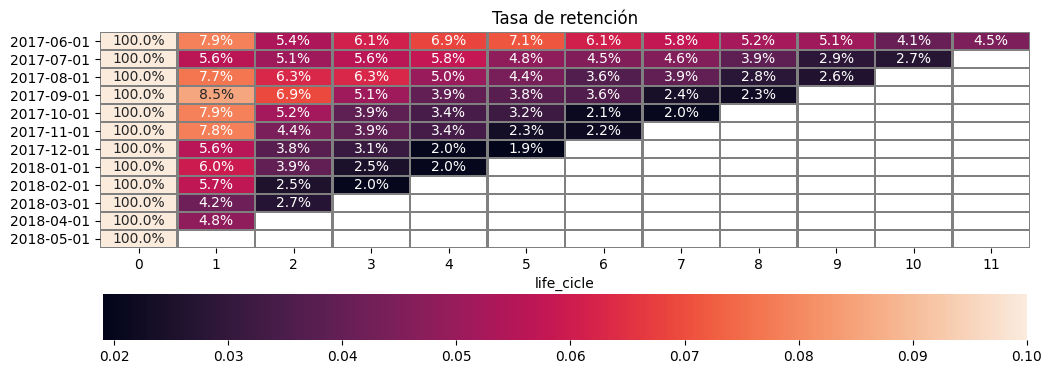

In [16]:
#Tasa de retención gráfica

retencion = pd.DataFrame()
for col in cohorts.columns:
    retencion = pd.concat([retencion, cohorts[col]/cohorts[0]], axis=1)
retencion.columns = cohorts.columns
retencion.index = [str(x)[0:10] for x in retencion.index]
plt.figure(figsize=(12, 4))
sns.heatmap(retencion, annot=True, fmt='.1%', linewidth=1, linecolor='grey', vmax= 0.1, cbar_kws={'orientation':'horizontal'}).set(title='Tasa de retención')
plt.show();

Observamos la tasa de retención de cada cohorte. Observamos que la tasa de retención cae drásticamente desde el primer mes, siendo menos del 10% en todas las cohortes, y así va disminuyendo progresivamente. Lo cual nos habla de que no hay un gran porcentaje de usuarios que regresen. La mayor tasa de retención fue de 8.5% en el primer mes de la cohorte que comenzó a comprar en septiembre del 2017, sin embargo sigue siendo muy baja y fue disminuyendo progresivamente hasta llegar a 2.3% en 8 meses. 
Asimismo podemos observar que a medida que avanza el tiempo, las cohortes suelen regresar menos, la última cohorte de abril del 2018 tuvo una caída del 4.8% en el primer mes. 
Algo hace falta para lograr que los usuarios regresen a comprar.

## Ventas

#### ¿Cuándo empieza la gente a comprar?

In [17]:
df_orders['buy_dt'] = pd.to_datetime(df_orders['Buy Ts']).dt.date
df_orders['order_month'] = pd.to_datetime(df_orders['buy_dt']).dt.to_period('M')
df_orders.head()

,Buy Ts,Revenue,Uid,buy_dt,order_month
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01,2017-06
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01,2017-06
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01,2017-06
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01,2017-06
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01,2017-06


In [18]:
#Encontrar primeras fechas
primeras_ordenes = df_orders.groupby('Uid').agg({'Buy Ts':'min'}).reset_index()
primeras_ordenes.columns = ['Uid', 'first_order_ts']
primeras_ordenes['first_order_dt'] = pd.to_datetime(primeras_ordenes['first_order_ts']).dt.date
primeras_ordenes['first_order_month'] = pd.to_datetime(primeras_ordenes['first_order_ts']).dt.to_period('M')
primeras_ordenes.head()

,Uid,first_order_ts,first_order_dt,first_order_month
0,313578113262317,2018-01-03 21:51:00,2018-01-03,2018-01
1,1575281904278712,2017-06-03 10:13:00,2017-06-03,2017-06
2,2429014661409475,2017-10-11 18:33:00,2017-10-11,2017-10
3,2464366381792757,2018-01-28 15:54:00,2018-01-28,2018-01
4,2551852515556206,2017-11-24 10:14:00,2017-11-24,2017-11


In [19]:
#Fusionar Dataset
compradores = pd.merge(primeras_visitas, primeras_ordenes, on='Uid')
compradores.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 36523 entries, 0 to 36522
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Uid                     36523 non-null  uint64        
 1   first_session_start_ts  36523 non-null  object        
 2   first_session_dt        36523 non-null  object        
 3   first_session_month     36523 non-null  datetime64[ns]
 4   first_order_ts          36523 non-null  object        
 5   first_order_dt          36523 non-null  object        
 6   first_order_month       36523 non-null  period[M]     
dtypes: datetime64[ns](1), object(4), period[M](1), uint64(1)
memory usage: 2.2+ MB


In [20]:
#cambiar dt
compradores['first_order_dt'] = pd.to_datetime(compradores['first_order_dt'])
compradores['first_session_dt'] = pd.to_datetime(compradores['first_session_dt'])
compradores['first_order_ts'] = pd.to_datetime(compradores['first_order_ts'])
compradores['first_session_start_ts'] = pd.to_datetime(compradores['first_session_start_ts'])
compradores.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 36523 entries, 0 to 36522
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Uid                     36523 non-null  uint64        
 1   first_session_start_ts  36523 non-null  datetime64[ns]
 2   first_session_dt        36523 non-null  datetime64[ns]
 3   first_session_month     36523 non-null  datetime64[ns]
 4   first_order_ts          36523 non-null  datetime64[ns]
 5   first_order_dt          36523 non-null  datetime64[ns]
 6   first_order_month       36523 non-null  period[M]     
dtypes: datetime64[ns](5), period[M](1), uint64(1)
memory usage: 2.2 MB


In [21]:
#Cuando empieza a comprar la gente
compradores['days_to_first_purchase'] = ((compradores['first_order_ts'] - compradores['first_session_start_ts']) / np.timedelta64(1, 'D')).astype('int')
compradores.head()

,Uid,first_session_start_ts,first_session_dt,first_session_month,first_order_ts,first_order_dt,first_order_month,days_to_first_purchase
0,313578113262317,2017-09-18,2017-09-18,2017-09-01,2018-01-03 21:51:00,2018-01-03,2018-01,107
1,1575281904278712,2017-06-03,2017-06-03,2017-06-01,2017-06-03 10:13:00,2017-06-03,2017-06,0
2,2429014661409475,2017-10-11,2017-10-11,2017-10-01,2017-10-11 18:33:00,2017-10-11,2017-10,0
3,2464366381792757,2018-01-27,2018-01-27,2018-01-01,2018-01-28 15:54:00,2018-01-28,2018-01,1
4,2551852515556206,2017-11-24,2017-11-24,2017-11-01,2017-11-24 10:14:00,2017-11-24,2017-11,0


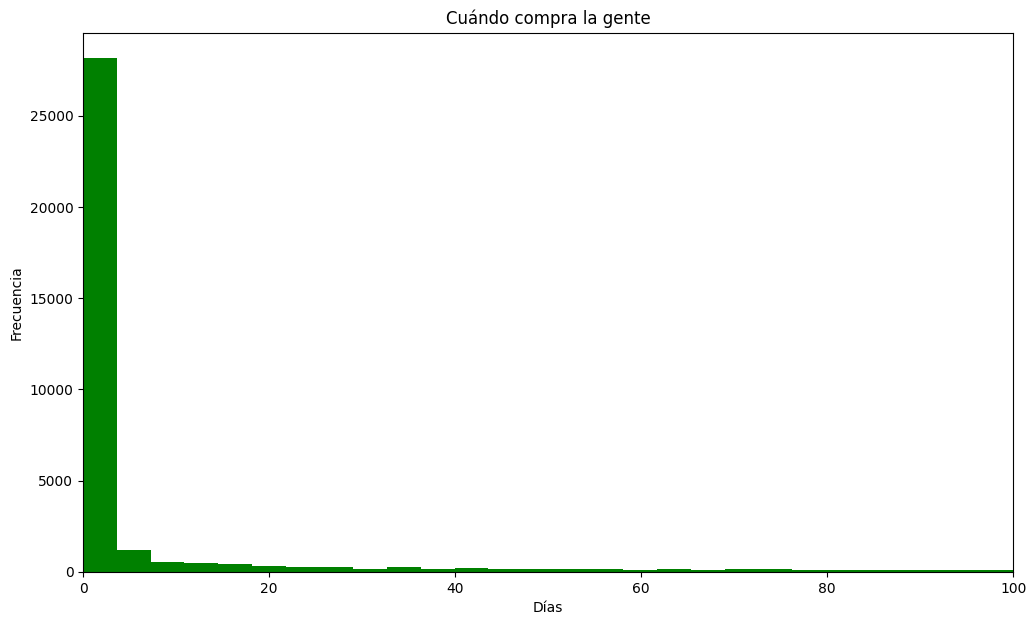

In [22]:
compradores['days_to_first_purchase'].plot(kind='hist', bins=100, figsize=(12,7), color='green').set(title='Cuándo compra la gente', xlabel='Días', ylabel='Frecuencia')
plt.xlim(0,100)
plt.show()

Es evidente que la mayoría de la gente compra el mismo día que visita por primera vez la página. Esto quiere decir que no tardan muchos días para convertirse de usuarios a clientes. Podemos observar que hay gente que puede tardar hasta más de 100 días en convertirse en cliente, sin embargo son muy pocos los usuarios que tardan más de 1 día.  

#### ¿Cuántos pedidos hacen durante un período de tiempo dado?

In [23]:
# Encontrar la cantidad de compradores por cada grupo
cohort_size = compradores.groupby('first_order_month').agg({'Uid': 'nunique'}).reset_index()
cohort_size.rename(columns = {'Uid': 'n_buyers'}, inplace=True)
cohort_size

,first_order_month,n_buyers
0,2017-06,2023
1,2017-07,1923
2,2017-08,1370
3,2017-09,2581
4,2017-10,4340
5,2017-11,4081
6,2017-12,4383
7,2018-01,3373
8,2018-02,3651
9,2018-03,3533


In [24]:
#Agregando primer mes
cohorts = pd.merge(df_orders, compradores, on='Uid', how='inner')
cohorts = cohorts.groupby(['first_order_month', 'order_month']).agg({'Revenue': 'count'}).reset_index()
cohorts.head()

,first_order_month,order_month,Revenue
0,2017-06,2017-06,2354
1,2017-06,2017-07,177
2,2017-06,2017-08,174
3,2017-06,2017-09,226
4,2017-06,2017-10,292


In [25]:
#Calcular ciclo de vida
cohorts['life_cicle'] = (cohorts['order_month'] - cohorts['first_order_month']).apply(lambda x: x.n)
cohorts.columns = ('first_order_month', 'order_month', 'n_orders', 'life_cicle')
cohorts.head()

,first_order_month,order_month,n_orders,life_cicle
0,2017-06,2017-06,2354,0
1,2017-06,2017-07,177,1
2,2017-06,2017-08,174,2
3,2017-06,2017-09,226,3
4,2017-06,2017-10,292,4


In [26]:
#Añadir clientes y contar órdenes
cohorts_report = pd.merge(cohort_size, cohorts, on='first_order_month')
cohorts_report['orders_per_buyer'] = cohorts_report['n_orders'] / cohorts_report['n_buyers']
cohorts_report.head()

,first_order_month,n_buyers,order_month,n_orders,life_cicle,orders_per_buyer
0,2017-06,2023,2017-06,2354,0,1.163618
1,2017-06,2023,2017-07,177,1,0.087494
2,2017-06,2023,2017-08,174,2,0.086011
3,2017-06,2023,2017-09,226,3,0.111715
4,2017-06,2023,2017-10,292,4,0.144340


In [27]:
#Graficar
cohorts_analyse = cohorts_report.pivot_table(
    index='first_order_month',
    columns='life_cicle',
    values= 'orders_per_buyer',
    aggfunc='sum'
).cumsum(1)
cohorts_analyse.round(2).fillna('')

life_cicle,0,1,2,3,4,5,6,7,8,9,10,11
first_order_month,,,,,,,,,,,,
2017-06,1.16,1.25,1.34,1.45,1.59,1.7,1.84,1.92,2.03,2.1,2.15,2.19
2017-07,1.14,1.19,1.25,1.31,1.34,1.39,1.42,1.44,1.47,1.49,1.51,
2017-08,1.12,1.2,1.27,1.33,1.39,1.44,1.47,1.53,1.56,1.6,,
2017-09,1.14,1.22,1.28,1.35,1.37,1.42,1.46,1.48,1.5,,,
2017-10,1.14,1.22,1.25,1.28,1.31,1.34,1.35,1.38,,,,
2017-11,1.18,1.28,1.32,1.37,1.41,1.42,1.45,,,,,
2017-12,1.15,1.21,1.26,1.3,1.32,1.34,,,,,,
2018-01,1.12,1.19,1.24,1.25,1.28,,,,,,,
2018-02,1.12,1.18,1.21,1.22,,,,,,,,


In [28]:
print('Promedio de órdenes por cliente', cohorts_analyse[5].mean(),2)

Promedio de órdenes por cliente 1.4341911542792218 2


Podemos ver que el promedio es 1.4 y no hay mucha variación en el promedio de compras de cada mes. Sin embargo, vemos que conforme pasan los meses, hacen más de 1.4 compras, lo que nos dice que los usuarios que siguen comprando conforme pasan los meses, suelen aumentar su número de compras. 

#### ¿Cuál es el tamaño promedio de compra?

In [29]:
print('Promedio de compras', round(df_orders['Revenue'].mean(),2))

Promedio de compras 5.0


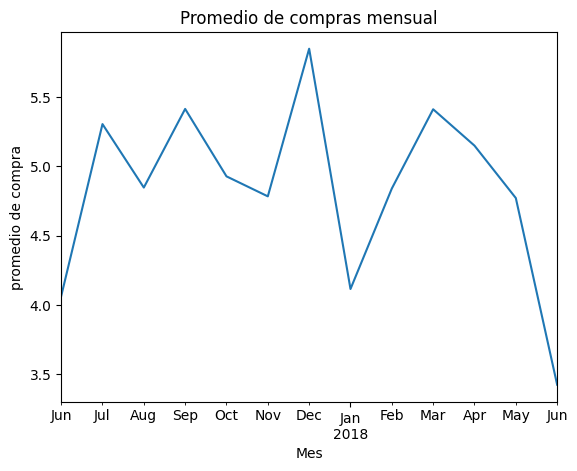

In [30]:
df_orders.pivot_table(
    index= 'order_month',
    values = 'Revenue',
    aggfunc = 'mean'
).plot(legend=None,).set(title='Promedio de compras mensual', xlabel='Mes', ylabel='promedio de compra')
plt.show()

Observamos que el ingreso promedio de compras es de 5, sin embargo algunos meses están muy por debajo del promedio como lo son enero del 2028, así como Noviembre del 2017. El mes que más compras tuvo en promedio, fue diciembre. 

#### ¿Cuánto dinero traen? (LTV)

In [31]:
#Ingreso total 
print('Ingreso total', df_orders['Revenue'].sum())

Ingreso total 252057.19999999998


In [32]:
# Número de clientes
cohort_size = compradores.groupby('first_order_month').agg({'Uid': 'nunique'}).reset_index()
cohort_size.rename(columns = {'Uid': 'n_buyers'}, inplace=True)
#Agregando primer mes
cohorts = pd.merge(df_orders, compradores, on='Uid', how='inner')
cohorts = cohorts.groupby(['first_order_month', 'order_month']).agg({'Revenue': 'sum'}).reset_index()
cohorts.head()

,first_order_month,order_month,Revenue
0,2017-06,2017-06,9557.49
1,2017-06,2017-07,981.82
2,2017-06,2017-08,885.34
3,2017-06,2017-09,1931.30
4,2017-06,2017-10,2068.58


In [33]:
# Ciclo de vida
cohorts['life_cicle'] = (cohorts['order_month'] - cohorts['first_order_month']).apply(lambda x: x.n)
cohorts.head()

,first_order_month,order_month,Revenue,life_cicle
0,2017-06,2017-06,9557.49,0
1,2017-06,2017-07,981.82,1
2,2017-06,2017-08,885.34,2
3,2017-06,2017-09,1931.30,3
4,2017-06,2017-10,2068.58,4


In [34]:
# Calcular LTV
cohorts_report = pd.merge(cohort_size, cohorts, on='first_order_month')
cohorts_report['LTV'] = cohorts_report['Revenue'] / cohorts_report['n_buyers']
cohorts_report.head()

,first_order_month,n_buyers,order_month,Revenue,life_cicle,LTV
0,2017-06,2023,2017-06,9557.49,0,4.724414
1,2017-06,2023,2017-07,981.82,1,0.485329
2,2017-06,2023,2017-08,885.34,2,0.437637
3,2017-06,2023,2017-09,1931.30,3,0.954671
4,2017-06,2023,2017-10,2068.58,4,1.022531


In [35]:
cohorts_ltv = cohorts_report.pivot_table(
    index= 'first_order_month',
    columns= 'life_cicle',
    values= 'LTV',
    aggfunc= 'sum'
).cumsum(axis=1)

cohorts_ltv.round(2).fillna('')

life_cicle,0,1,2,3,4,5,6,7,8,9,10,11
first_order_month,,,,,,,,,,,,
2017-06,4.72,5.21,5.65,6.6,7.62,8.36,9.31,9.89,10.45,11.05,11.62,11.88
2017-07,6.01,6.35,6.97,7.33,7.5,7.66,7.78,7.92,8.08,8.23,8.39,
2017-08,5.28,5.75,6.21,6.6,7.09,7.38,7.59,7.99,8.28,8.47,,
2017-09,5.64,6.76,7.28,11.26,11.66,12.31,13.01,13.25,13.44,,,
2017-10,5.00,5.54,5.73,5.89,6.04,6.16,6.24,6.36,,,,
2017-11,5.15,5.55,5.75,6.08,6.23,6.28,6.4,,,,,
2017-12,4.74,5.0,5.92,6.99,7.3,7.64,,,,,,
2018-01,4.14,4.43,4.73,4.88,4.94,,,,,,,
2018-02,4.16,4.44,4.51,4.59,,,,,,,,


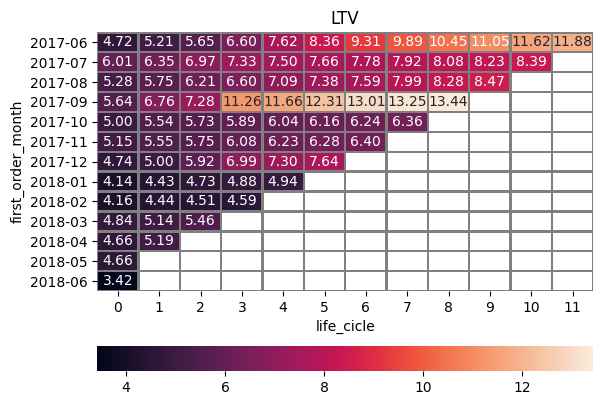

In [36]:
cohorts_ltv.index = cohorts_ltv.index.astype(str)
sns.heatmap(cohorts_ltv, annot=True, fmt='.2f', linewidths=1, linecolor='grey', cbar_kws={'orientation':'horizontal'}).set(title='LTV')
plt.show;

Observamos el crecimiento natural del LTV, conforme avanza el ciclo de vida el LTV aumenta, lo cual es esperado. Observamos que hay alguna cohortes que retienen mejor y alcanzan un LTV mucho mayor como 2017-09 que alcanza hasta 13.44. 
En conclusión observamos que la empresa logra recuperar bastante valor en los primero 3-4 meses (mucho del LTV se genera rápido), después el crecimiento del LTV sigue pero se desacelera. 
Un problema que podemos observar es que las cohortes más recientes parecen menos rentables, pues encontramos valores más bajos de LTV desde el primer mes. 

## Marketing

#### ¿Cuánto dinero se gastó?

In [37]:
#Sumar costos para obtener costos totales
print('Costos totales', df_costs['costs'].sum())

Costos totales 329131.62


Si lo comparamos con el ingreso total (252057.19999999998), es menor. 

In [38]:
#Extrayendo costos mensuales
df_costs['costs_month'] = pd.to_datetime(df_costs['dt']).dt.to_period('M')
df_costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype    
---  ------       --------------  -----    
 0   source_id    2542 non-null   int64    
 1   dt           2542 non-null   object   
 2   costs        2542 non-null   float64  
 3   costs_month  2542 non-null   period[M]
dtypes: float64(1), int64(1), object(1), period[M](1)
memory usage: 79.6+ KB


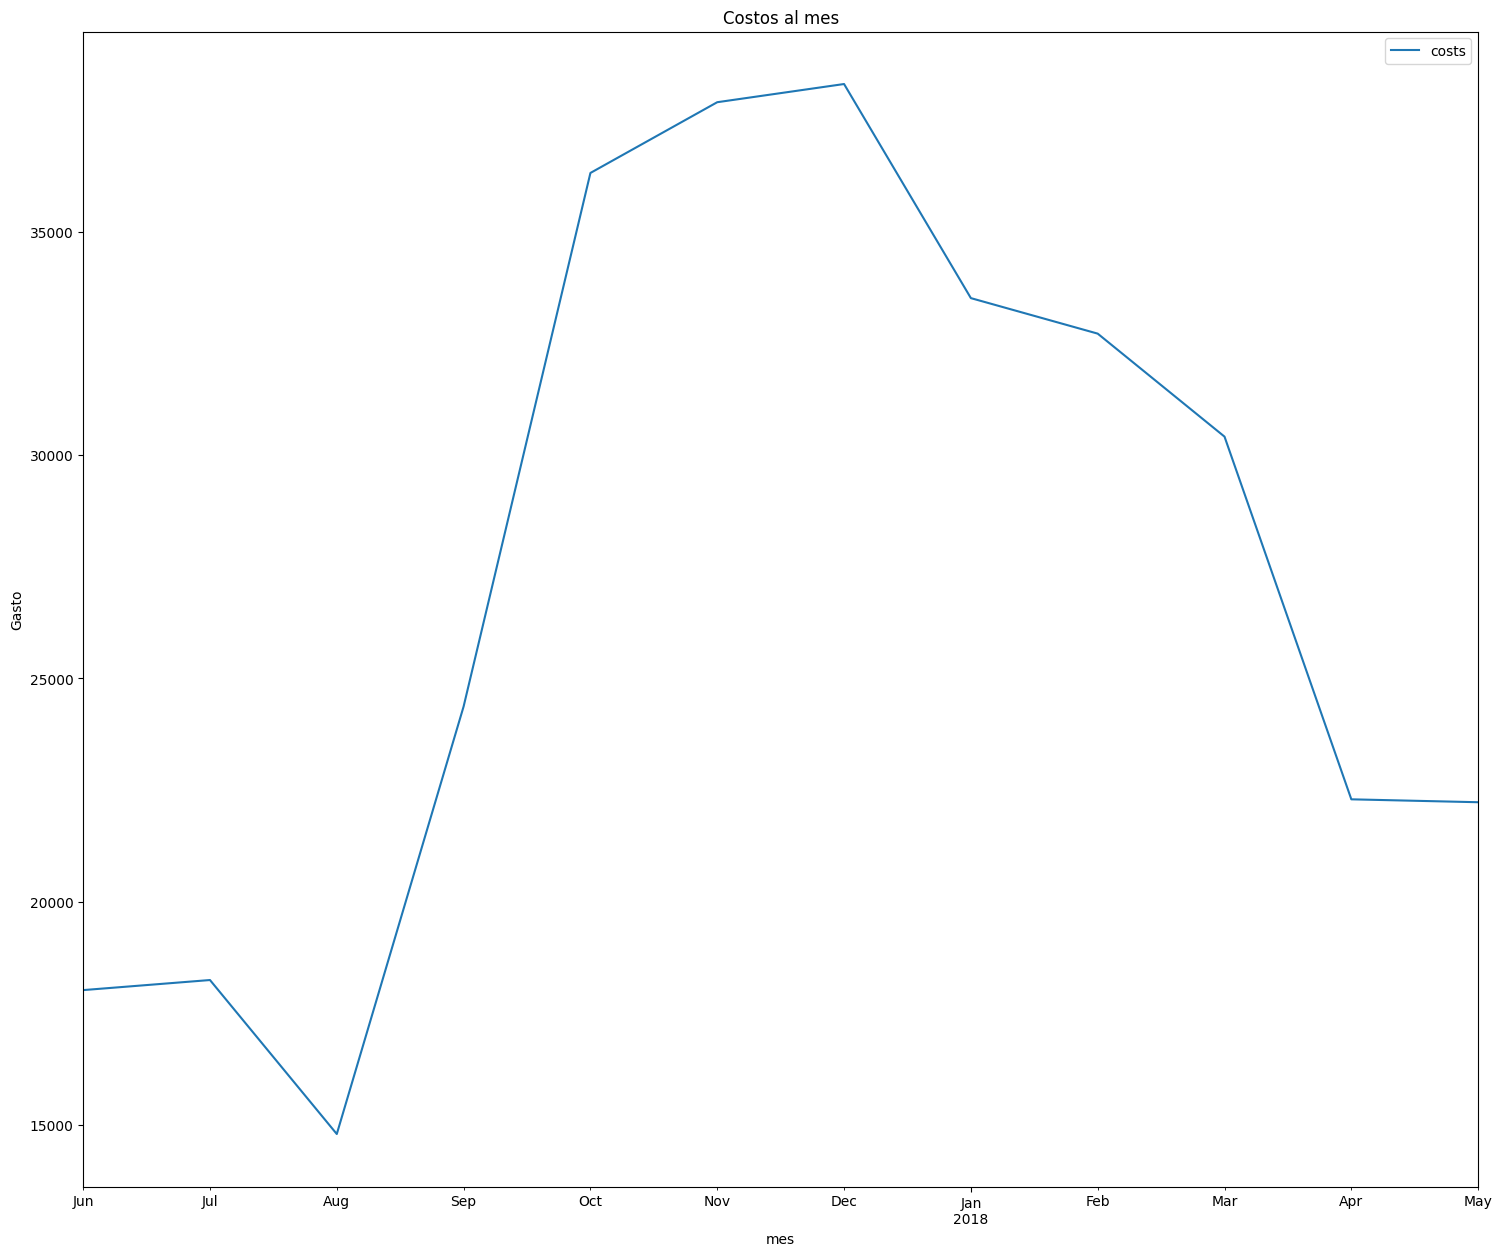

In [39]:
# Graficar cuánto dinero se gastó por mes
df_costs.pivot_table(
    index='costs_month',
    values= 'costs',
    aggfunc = 'sum'
).plot(figsize=(18,15), title= 'Costos al mes', xlabel='mes', ylabel='Gasto')
plt.show()

Podemos observar que en agosto hubo una caída en inversión en marketing, sin embargo despúes de agosto comienza a subir el gasto súbita y progresivamente, llegando a su pico máximo en diciembre y observando de nuevo una disminución progresiva a partir de enero del 2018. Si lo comparamos con las ventas coincide que en diciembre es el mes con más ventas. 

In [40]:
#Dinero gastado por fuente de adquisión
print('Costos por fuente de adquisión')
df_costs.groupby('source_id').agg({'costs':'sum'}).reset_index()

Costos por fuente de adquisión


,source_id,costs
0,1,20833.27
1,2,42806.04
2,3,141321.63
3,4,61073.60
4,5,51757.10
5,9,5517.49
6,10,5822.49


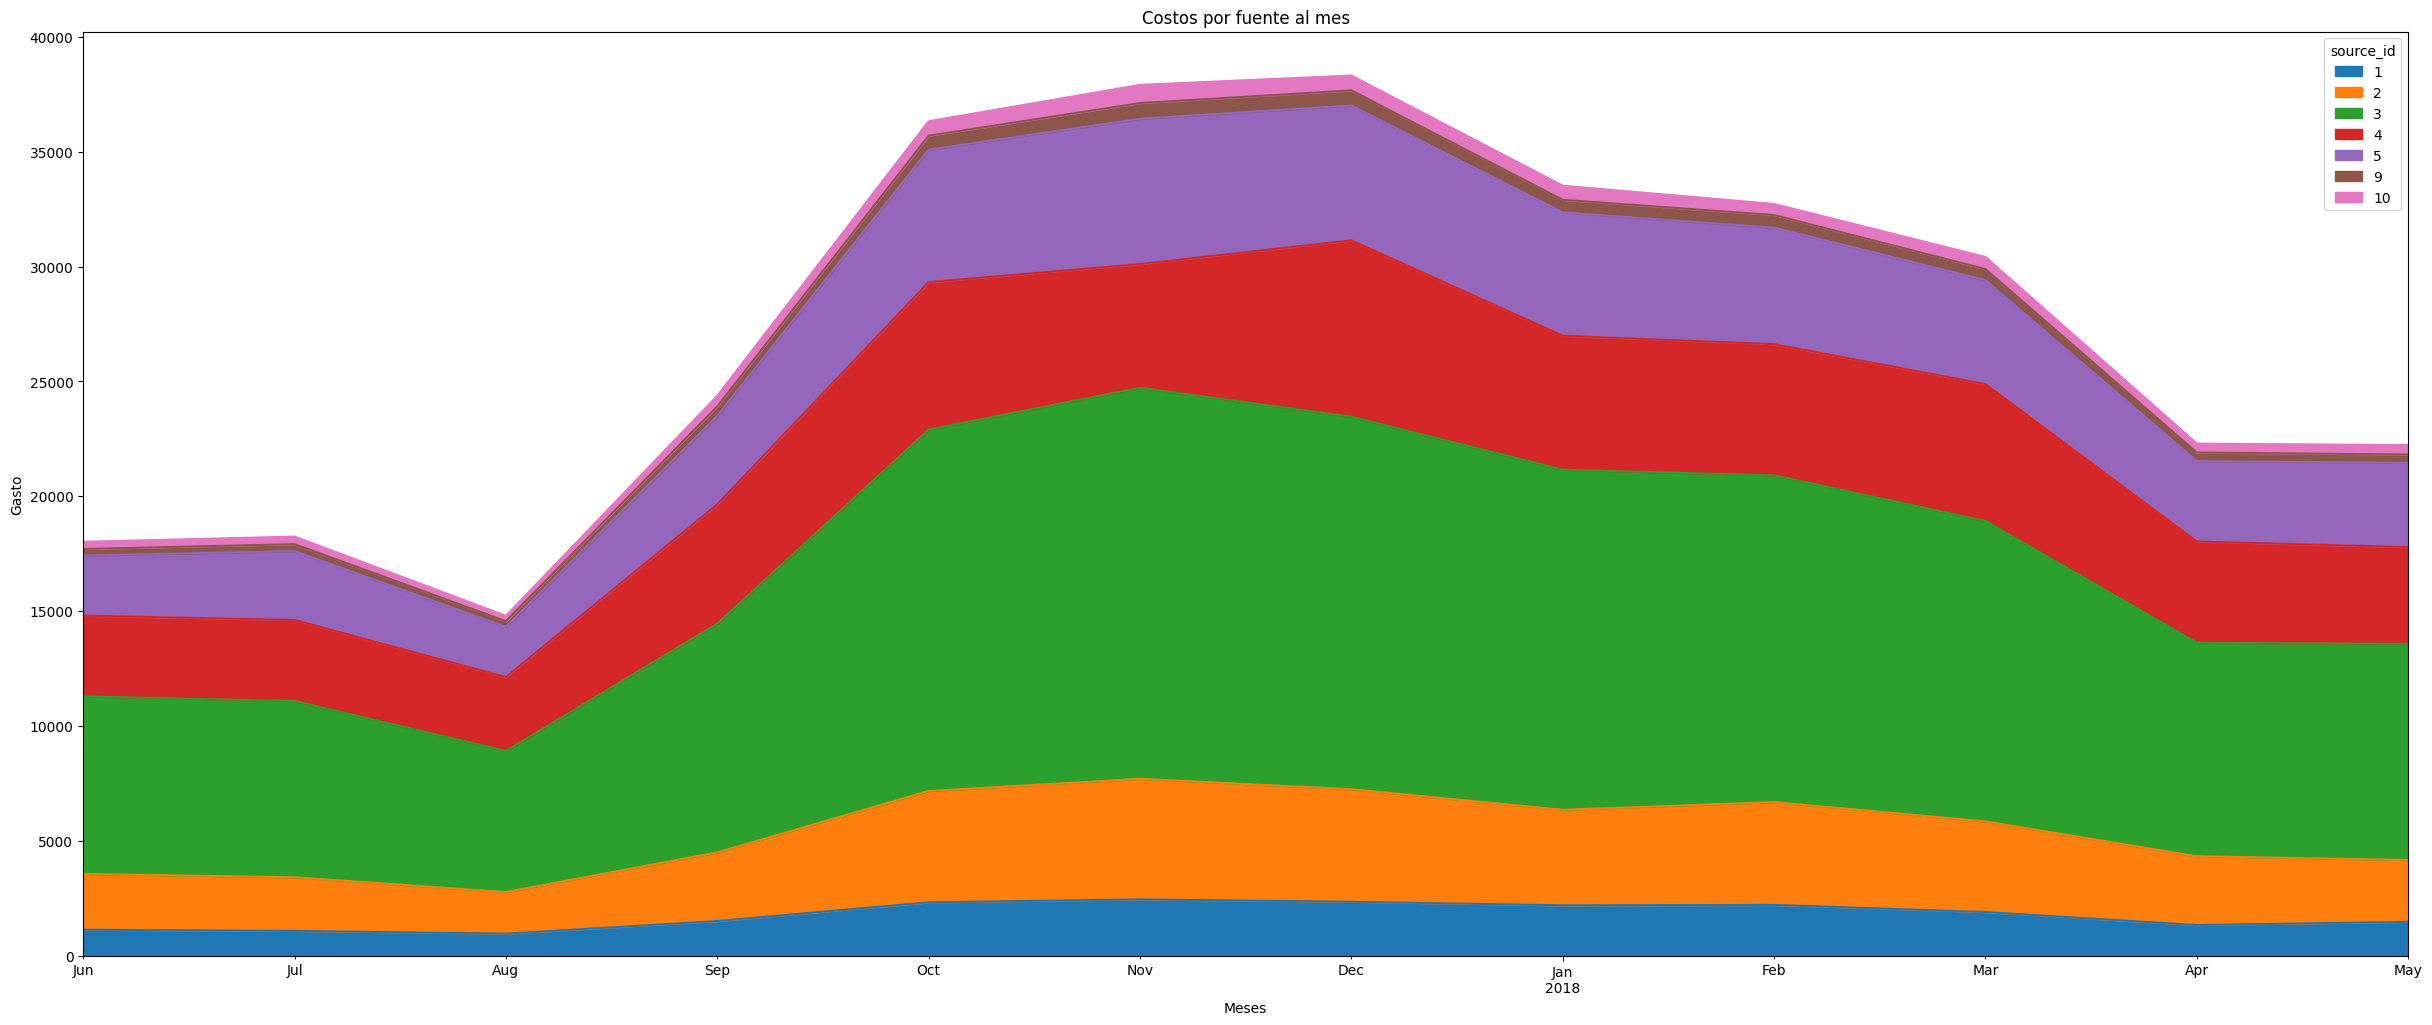

In [41]:
#Gráfico por fuente de adquisión a través del tiempo
df_costs.pivot_table(
    index= 'costs_month',
    columns = 'source_id',
    values= 'costs',
    aggfunc= 'sum'
).plot.area(figsize=(30,12), title='Costos por fuente al mes', xlabel='Meses', ylabel= 'Gasto')
plt.show();

Observamos que la fuente de adquisión que tuvo gastos más elevados es la 10, seguida de la 9 y 5. Vemos que la fuente que menos gastos generó fue la 1. Sin embargo tendríamos que calcular el retrono de inversión (ROMI), para analizar si realmente valió la pena el gasto y en términos de inversión cuál fuente realmente fue la más costosa. 

#### ¿Cuál fue el costo de adquisición de clientes de cada una de las fuentes?

In [42]:
#Atribuir cada usuario a la fuente de su primer sesion
# asegurar tipos de fecha por si hace falta
df_visits['Start Ts'] = pd.to_datetime(df_visits['Start Ts'])
df_orders['Buy Ts']   = pd.to_datetime(df_orders['Buy Ts'])
df_costs['dt']        = pd.to_datetime(df_costs['dt'])

# primera sesión por usuario (timestamp)
first_session = (
    df_visits
    .sort_values(['Uid','Start Ts'])
    .groupby('Uid', as_index=False)
    .first()[['Uid','Start Ts','Source Id']]
    .rename(columns={'Start Ts':'first_session_ts',
                     'Source Id':'first_source'})
)

# usuarios que alguna vez compraron (clientes)
buyers = df_orders[['Uid']].drop_duplicates()
first_touch_buyers = buyers.merge(first_session, on='Uid', how='left')

In [43]:
#CAC toTal por fuente
# clientes por fuente de adquisición
customers_by_source = (
    first_touch_buyers
    .groupby('first_source', as_index=False)['Uid']
    .nunique()
    .rename(columns={'Uid':'customers'})
)

# gasto total por fuente
costs_by_source = (
    df_costs
    .groupby('source_id', as_index=False)['costs']
    .sum()
    .rename(columns={'source_id':'first_source', 'costs':'total_cost'})
)

# CAC total por fuente
cac_by_source = (
    customers_by_source
    .merge(costs_by_source, on='first_source', how='left')
)
cac_by_source['CAC'] = cac_by_source['total_cost'] / cac_by_source['customers']

cac_by_source = cac_by_source.sort_values('CAC', ascending=False)
cac_by_source

,first_source,customers,total_cost,CAC
2,3,10473,141321.63,13.493901
1,2,3506,42806.04,12.209367
4,5,6931,51757.10,7.467479
0,1,2899,20833.27,7.186364
3,4,10296,61073.60,5.931779
6,9,1088,5517.49,5.071222
7,10,1329,5822.49,4.381106
5,7,1,NaN,NaN


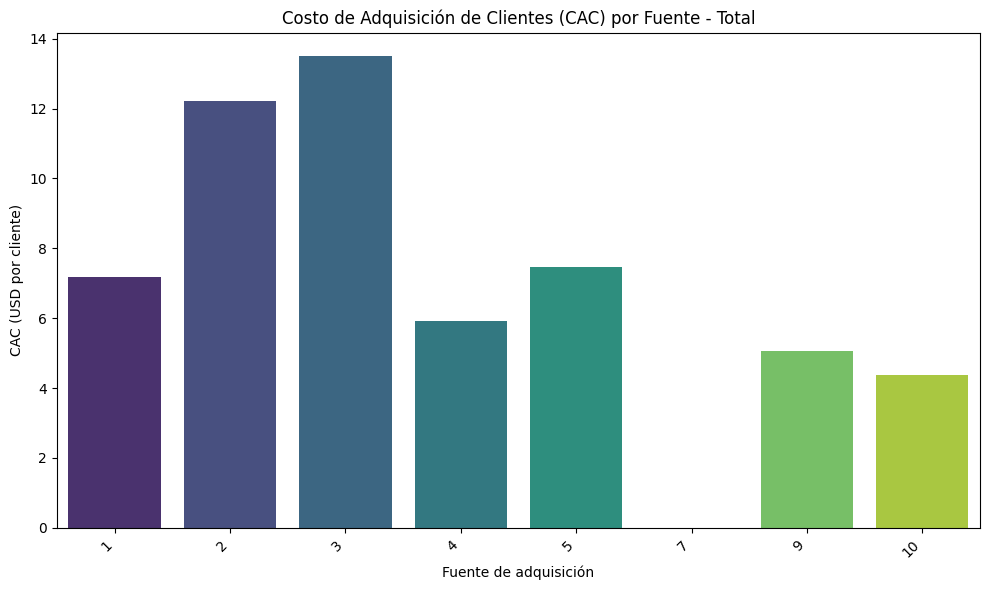

In [44]:
# ordenar de mayor a menor CAC
cac_sorted = cac_by_source.sort_values('CAC', ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(data=cac_sorted, x='first_source', y='CAC', palette='viridis')

plt.title('Costo de Adquisición de Clientes (CAC) por Fuente - Total')
plt.xlabel('Fuente de adquisición')
plt.ylabel('CAC (USD por cliente)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

Observamos que la fuente de adquisión que tuvo un mayor CAC fue la 3 con casi 14 USD, seguida de la 2. 

In [45]:
#CAC mensual por fuente 
# mes de primera sesión
first_touch_buyers['first_session_month'] = first_touch_buyers['first_session_ts'].dt.to_period('M').dt.to_timestamp()

# nuevos clientes por fuente y mes
customers_source_month = (
    first_touch_buyers
    .groupby(['first_source','first_session_month'], as_index=False)['Uid']
    .nunique()
    .rename(columns={'Uid':'new_customers'})
)

# costos por fuente y mes
df_costs['month'] = df_costs['dt'].dt.to_period('M').dt.to_timestamp()
costs_source_month = (
    df_costs
    .groupby(['source_id','month'], as_index=False)['costs']
    .sum()
    .rename(columns={'source_id':'first_source','month':'first_session_month'})
)

# CAC mensual
cac_monthly = customers_source_month.merge(costs_source_month,
                                           on=['first_source','first_session_month'],
                                           how='left')
cac_monthly['CAC'] = cac_monthly['costs'] / cac_monthly['new_customers']

# Ordenar bonito
cac_monthly = cac_monthly.sort_values(['first_session_month','first_source'])
cac_monthly.head(20)

,first_source,first_session_month,new_customers,costs,CAC
0,1,2017-06-01,240,1125.61,4.690042
12,2,2017-06-01,374,2427.38,6.490321
24,3,2017-06-01,886,7731.65,8.726467
36,4,2017-06-01,647,3514.80,5.432457
48,5,2017-06-01,509,2616.12,5.139725
61,9,2017-06-01,154,285.22,1.852078
73,10,2017-06-01,113,314.22,2.780708
1,1,2017-07-01,184,1072.88,5.830870
13,2,2017-07-01,278,2333.11,8.392482
25,3,2017-07-01,665,7674.37,11.540406


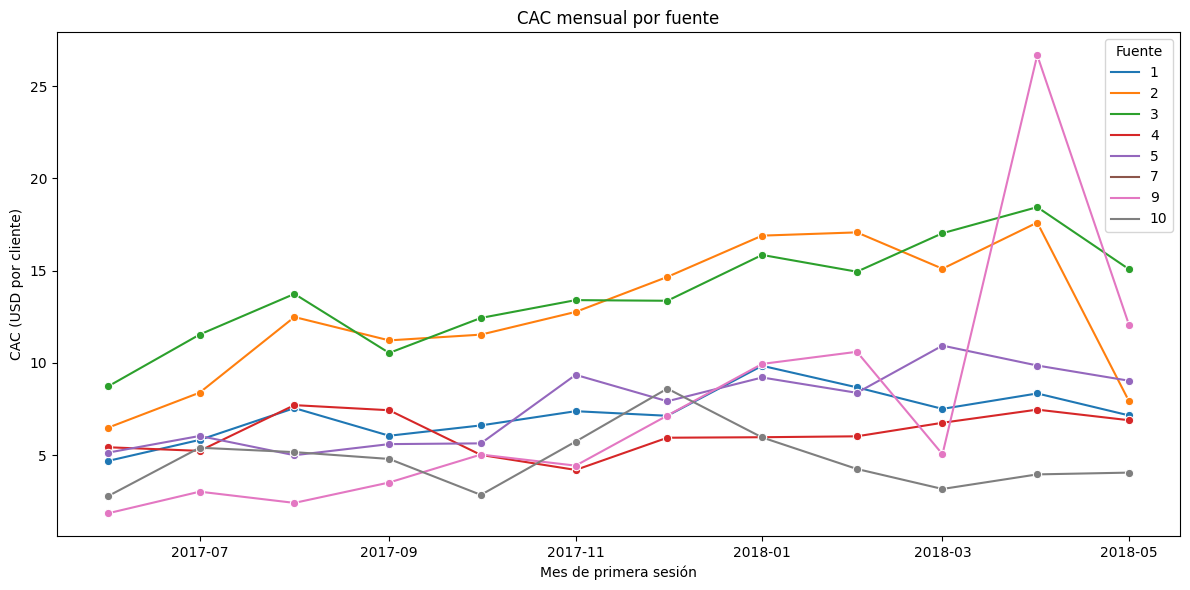

In [46]:
plt.figure(figsize=(12,6))
sns.lineplot(
    data=cac_monthly,
    x='first_session_month',
    y='CAC',
    hue='first_source',
    marker='o',
    palette='tab10'
)

plt.title('CAC mensual por fuente')
plt.xlabel('Mes de primera sesión')
plt.ylabel('CAC (USD por cliente)')
plt.legend(title='Fuente')
plt.tight_layout()
plt.show()

Observamos que el mes en el que más se gastó CAC fue en 04 del 2018. La fuente en la que más hubo gasto ese mes por CAC fue en la 9, con un gasto de CAC de más de 25 USD. Sin embargo las fuentes que se mantuvieron con gasto de CAC más alto fue en la fuente 2 y 3 con un aproximado de entre 10-15 USD. Por último podemos observar un aumento del CAC con el tiempo, siendo este progresivamente más alto en la mayoría de las fuentes. Con ligeras variaciones en algunos meses. 

#### ¿Cuán rentables eran las inversiones? (ROMI)

In [47]:
#ROMI total por fuente
# revenue por usuario
revenue_by_user = (
    df_orders
    .groupby('Uid', as_index=False)['Revenue']
    .sum()
    .rename(columns={'Revenue':'user_revenue'})
)

# revenue por fuente (first touch)
revenue_by_source = (
    first_session[['Uid','first_source']]
    .merge(revenue_by_user, on='Uid', how='left')
    .groupby('first_source', as_index=False)['user_revenue']
    .sum()
    .rename(columns={'user_revenue':'revenue'})
)

# unir con costos totales
romi_by_source = revenue_by_source.merge(costs_by_source, on='first_source', how='left')

romi_by_source['ROMI'] = (romi_by_source['revenue'] - romi_by_source['total_cost']) / romi_by_source['total_cost']

romi_by_source = romi_by_source.sort_values('ROMI', ascending=False)
romi_by_source

,first_source,revenue,total_cost,ROMI
0,1,31090.55,20833.27,0.492351
1,2,46923.61,42806.04,0.096191
7,9,5759.40,5517.49,0.043844
4,5,52624.02,51757.10,0.016750
3,4,56696.83,61073.60,-0.071664
8,10,4450.33,5822.49,-0.235665
2,3,54511.24,141321.63,-0.614275
5,6,0.00,NaN,NaN
6,7,1.22,NaN,NaN


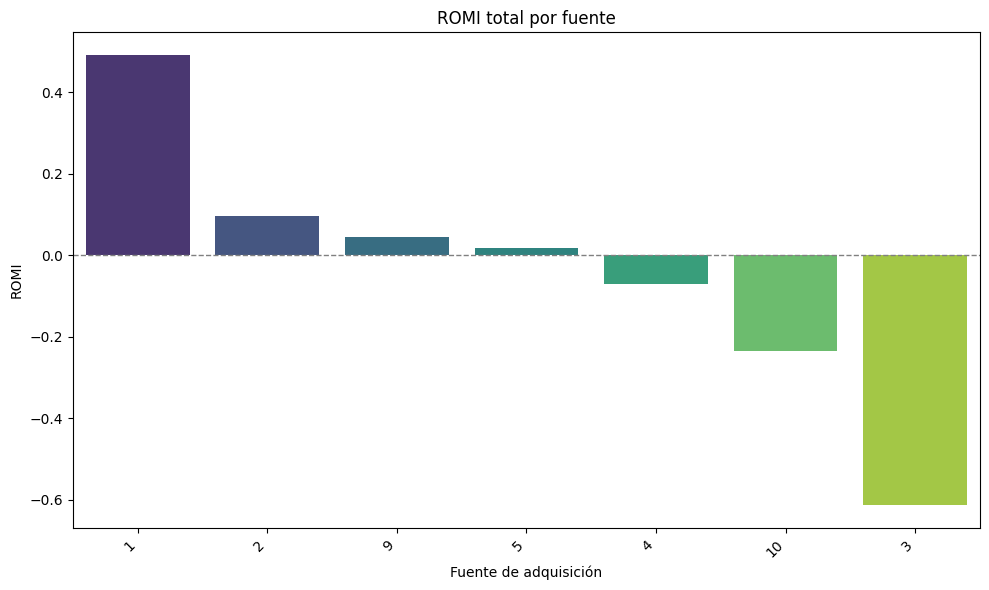

In [48]:
# al menos forzamos a str/categorical
romi_by_source = romi_by_source.dropna(subset=['first_source', 'ROMI']).copy()
romi_by_source['first_source'] = romi_by_source['first_source'].astype(str)

# ordenar por ROMI para lectura
order = romi_by_source.sort_values('ROMI', ascending=False)['first_source']
plt.figure(figsize=(10,6))
sns.barplot(data=romi_by_source, x='first_source', y='ROMI', order=order, palette='viridis')

plt.title('ROMI total por fuente')
plt.xlabel('Fuente de adquisición')
plt.ylabel('ROMI')
plt.xticks(rotation=45, ha='right')
# línea de referencia 
plt.axhline(0, ls='--', color='gray', lw=1)
plt.tight_layout()
plt.show()

En esta gráfica vemos claramente las fuentes que tuvieron mejor ROMI: siendo la 1, seguida de la 2 y la 9. Vemos que la fuente de adquisión 5 estuvo casi en un ROMI de 0. Y las demás fuentes tuvieron pérdidas, con ROMI con valor negativo. Tendríamos que evaluar con el equipo de marqueting si es conveniente seguir invirtiendo en esas fuentes. 

In [49]:
#ROMI mensual por fuente
# revenue por cohorte (mes de primera sesión) y fuente
rev_source_month = (
    first_session.assign(first_session_month=lambda x: x['first_session_ts'].dt.to_period('M').dt.to_timestamp())
    .merge(df_orders[['Uid','Revenue']], on='Uid', how='left')
    .groupby(['first_source','first_session_month'], as_index=False)['Revenue']
    .sum()
    .rename(columns={'Revenue':'cohort_revenue'})
)

# juntar con costos del mismo mes/fuente
romi_monthly = rev_source_month.merge(costs_source_month,
                                      on=['first_source','first_session_month'],
                                      how='left')

romi_monthly['ROMI'] = (romi_monthly['cohort_revenue'] - romi_monthly['costs']) / romi_monthly['costs']

romi_monthly = romi_monthly.sort_values(['first_session_month','first_source'])
romi_monthly.head(20)

,first_source,first_session_month,cohort_revenue,costs,ROMI
0,1,2017-06-01,9910.69,1125.61,7.804728
12,2,2017-06-01,7786.56,2427.38,2.207804
24,3,2017-06-01,5863.70,7731.65,-0.241598
36,4,2017-06-01,9636.70,3514.80,1.741749
48,5,2017-06-01,5399.05,2616.12,1.063762
62,7,2017-06-01,0.00,NaN,NaN
74,9,2017-06-01,1107.47,285.22,2.882862
86,10,2017-06-01,321.88,314.22,0.024378
1,1,2017-07-01,2341.21,1072.88,1.182173
13,2,2017-07-01,2974.66,2333.11,0.274976


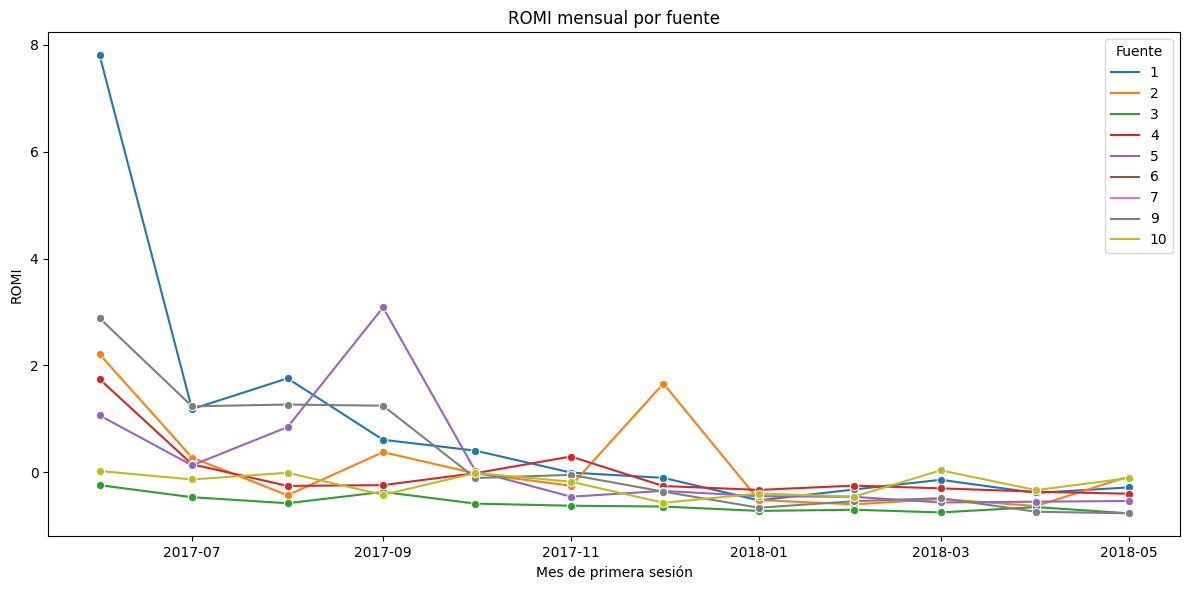

In [50]:
#Graficar 
plt.figure(figsize=(12,6))
sns.lineplot(
    data=romi_monthly,
    x='first_session_month',
    y='ROMI',
    hue='first_source',
    marker='o',
    palette='tab10'
)

plt.title('ROMI mensual por fuente')
plt.xlabel('Mes de primera sesión')
plt.ylabel('ROMI')
plt.legend(title='Fuente')
plt.tight_layout()
plt.show()

Vemos que las fuentes en general tienen el mismo ROMI conforme pasa el tiempo, ya que se van unificando en los últimos meses de la campaña, con un romi muy bajo todas. Sin embargo al inicio vemos algunas diferencias, siendo signficativamente mayor el ROMI en la fuente 1, lo que nos podría indicar que es una mejor compaña, sin embargo tiene una fuerte caída conforme pasa el tiempo. Asímismo en la fuente 2 y 5 vemos algunos picos de aumento del ROMI sobre todo en los meses 09 2017 y 10 2017. Tendríamos que investigar porqué conforme pasa el tiempo el romi fue diminuyendo, ¿Dejaron de ser efectivas las campañas?

# Conclusión y recomendaciones para el equipo de Marketing

El análisis de los datos de ventas, visitas y marketing nos permitió identificar patrones clave en el comportamiento de los usuarios y la efectividad de las inversiones de marketing, estos datos pueden ser relevantes para futuras decisiones en cuanto a campañas de marketing. A continuación enlisto las conclusiones que considero más relevantes obtenidas de las distintas métricas y KPIs que utilizamos en las 3 áreas previamente mencionadas: 

1. Comportamiento de usuarios y ventas
	•	Los jueves y viernes son los días con mayor tráfico, lo que sugiere que la comunicación y campañas deberían intensificarse en esos días.
	•	La duración promedio de las sesiones (643s) refleja un interés alto en la plataforma, aunque la mayoría de los usuarios solo realizan una sesión por día.
	•	La retención de usuarios cae drásticamente en el primer mes, por lo que la estrategia debería enfocarse en fidelizar a los nuevos clientes desde la primera compra (ej.: programas de recompensas, descuentos para la segunda compra).
	•	La mayoría de usuarios convierten el mismo día de la primera visita, lo que resalta la importancia de un marketing de impacto inmediato.
	•	En cuanto a la recurrencia: la mayoría hace 1 pedido (máximo 2), pero aquellos que permanecen tienden a incrementar su número de compras. Esto indica que hay un nicho valioso de clientes leales que deben ser incentivados con campañas de retención.

2. Ingresos y rentabilidad (LTV)
	•	El LTV se recupera en gran parte durante los primeros 3–4 meses, después de ese periodo el crecimiento desacelera notablemente.
	•	Las cohortes más recientes presentan un LTV inicial más bajo, lo que sugiere que las campañas de adquisición recientes no están trayendo clientes de calidad comparable a las primeras.

3. Marketing: inversión, CAC y ROMI
	•	Hubo un gasto de marketing desproporcionado en diciembre, sin que esto se tradujera en una mejora clara en retención o LTV, lo que indica una inversión poco eficiente.
	•	CAC más alto: Fuente 3, seguida de la fuente 2 → significa que atraer clientes por esas fuentes es más costoso.
	•	ROMI más alto: Fuente 1, seguida de la fuente 2 → indica que esas son las fuentes más rentables en términos de retorno.

4. Recomendaciones
	•	Invertir prioritariamente en la Fuente 1, ya que presenta el mejor ROMI, garantizando rentabilidad.
	•	Mantener inversión controlada en la Fuente 2, ya que aunque su CAC es relativamente alto, sigue mostrando un buen nivel de ROMI.
	•	Reducir o reestructurar la inversión en la Fuente 3, pues su CAC es demasiado elevado y no compensa en retorno.
	•	Rediseñar las campañas de diciembre para mejorar la eficiencia (ej.: segmentación más precisa, promociones ligadas a recurrencia).
	•	Implementar estrategias de fidelización en el primer mes (correo de bienvenida, descuentos en la segunda compra, membresías de puntos), para reducir la caída de retención temprana.
	•	Aprovechar los jueves y viernes como días clave para promociones y anuncios, ya que concentran mayor